In [334]:
import os
import json
import scipy
import requests
import ftfy
import unicodedata
import itertools
import random
import pickle

import sklearn as sk
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pathlib import Path
from spgmi.utils import bigram_embedder

pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [247]:
districts = pd.read_csv(Path('..') / '..' / 'data' / 'descriptives.csv')
laws = pd.read_csv(Path('..') / '..' / 'data' / 'plans' / 'doi_final.csv')

Two data sets here, one that is district informational data that we received from the state, another that is our classified laws for each of those districts. First task will be to merge them into one workable set for analysis.

In [248]:
districts.head()

,Name,district,Type,Description,type_rural,type_nonmetro_stable,type_nonmetro_growing,type_town,type_citysuburb,type_city,type_urbansuburb,type_urban,distname,campus_count,rating,v1,eng1_numtakers,alg_numtakers,r_7th_numtakers,m_7th_numtakers,eng2_numtakers,r_3rd_numtakers,m_3rd_numtakers,us_numtakers,bio_numtakers,r_4th_numtakers,m_4th_numtakers,r_5th_numtakers,m_5th_numtakers,r_8th_numtakers,m_8th_numtakers,r_6th_numtakers,m_6th_numtakers,cntyname,distischarter,teachers_new_num,teachers_phddegree_num,teachers_tenure_ave,teachers_badegree_num,teachers_exp_ave,teachers_nodegree_num,teachers_msdegree_num,students_hisp_num,students_num,teachers_num,students_frpl_num,teachers_turnover_denom,students_white_num,teachers_turnover_ratio,students_black_num,teacher_turnover_num,treated,approxareasqkilometers,approxareaussurveyacres,district_miles
0,A W BROWN-FELLOWSHIP LEADERSHIP AC,57816,I,CHARTER SCHOOL DISTRICTS,0,0,0,0,0,0,0,0,A W BROWN-FELLOWSHIP LEADERSHIP AC,2,M,1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DALLAS,Y,7.0,0.0,4.6,69.000000,8.2,11.0,25.900000,63,2161,208.000000,1796,102.000000,8,19.600000,2076,20.000000,False,NaN,NaN,NaN
1,A+ ACADEMY,57829,I,CHARTER SCHOOL DISTRICTS,0,0,0,0,0,0,0,0,A+ ACADEMY,1,M,228,68.0,59.0,83.0,1619.0,72.0,58.0,1406.0,65.0,72.0,70.0,1482.0,69.0,1525.0,80.0,1658.0,66.0,1608.0,DALLAS,Y,10.6,3.9,3.0,37.299999,9.4,2.7,25.700001,863,940,136.500000,854,73.000000,31,33.099998,30,24.200001,False,NaN,NaN,NaN
2,ABBOTT ISD,109901,H,RURAL,1,0,0,0,0,0,0,0,ABBOTT ISD,1,M,482,19.0,19.0,15.0,1698.0,19.0,17.0,1488.0,22.0,15.0,16.0,1557.0,20.0,1681.0,23.0,1719.0,20.0,1700.0,HILL,N,0.0,0.0,10.7,21.000000,16.4,0.0,3.200000,28,269,37.900002,76,24.200001,231,4.600000,0,1.100000,True,194.74800,48123.133,75.192001
3,ABERNATHY ISD,95901,H,RURAL,1,0,0,0,0,0,0,0,ABERNATHY ISD,4,M,394,69.0,65.0,56.0,1699.0,44.0,62.0,1444.0,27.0,55.0,56.0,1554.0,48.0,1620.0,65.0,1706.0,49.0,1667.0,HALE,N,2.0,0.0,7.7,62.500000,14.6,0.0,3.200000,447,779,120.900000,428,66.500000,314,13.500000,5,9.000000,True,469.40500,115991.960,181.237000
4,ABILENE ISD,221901,C,OTHER CENTRAL CITY,0,0,0,0,0,1,0,0,ABILENE ISD,33,M,895,1166.0,1010.0,1058.0,1566.0,1105.0,1305.0,1447.0,1775.0,1046.0,1242.0,1545.0,1245.0,1587.0,1102.0,1674.0,1198.0,1625.0,TAYLOR,N,56.0,4.4,9.7,896.400020,13.1,7.0,222.700000,7395,16875,2400.600100,11203,1142.300000,6321,17.299999,2083,198.000000,True,276.22101,68255.414,106.649000


In [249]:
laws.head()

,Unnamed: 0,district,level,type,link,p_doi,date,date_p,reg1_251,reg1_253,reg102_1301,reg102_1303,reg102_1305,reg102_1307,reg102_1309,reg102_1311,reg102_1313,reg102_1315,reg102_309,reg109_1001,reg11_1511,reg11_1512,reg11_162,reg11_164,reg11_251,reg11_252,reg11_253,reg11_255,reg12_003,reg12_0522,reg12_131,reg130_135,reg130_231,reg130_413,reg132_231,reg15_113,reg150_1001,reg150_1003,reg150_1022,reg150_1026,reg158_211,reg16_057,reg19_231,reg21_0003,reg21_002,reg21_003,reg21_0031,reg21_004,reg21_005,reg21_04,reg21_0401,reg21_044,reg21_0442,reg21_048,reg21_0487,reg21_049,reg21_0491,reg21_051,reg21_052,reg21_053,reg21_055,reg21_056,reg21_057,reg21_0583,reg21_081,reg21_0811,reg21_101,reg21_102,reg21_106,reg21_111,reg21_158,reg21_202,reg21_203,reg21_211,reg21_252,reg21_351,reg21_352,reg21_353,reg21_354,reg21_3541,reg21_355,reg21_401,reg21_402,reg21_4021,reg21_4022,reg21_403,reg21_4031,reg21_4032,reg21_404,reg21_405,reg21_406,reg21_407,reg21_408,reg21_409,reg21_415,reg21_422,reg21_451,reg21_4513,reg21_452,reg21_458,reg212_3541,reg22_001,reg22_002,reg22_003,reg22_006,reg22_007,reg22_011,reg22_021,reg22_0831,reg22_0833,reg22_111,reg22_902,reg23_354,reg23_3541,reg231_611,reg24_401,reg25_001,reg25_002,reg25_0021,reg25_0031,reg25_004,reg25_01812,reg25_035,reg25_036,reg25_038,reg25_043,reg25_08,reg25_081,reg25_0811,reg25_0812,reg25_082,reg25_083,reg25_084,reg25_085,reg25_086,reg25_087,reg25_0915,reg25_092,reg25_094,reg25_111,reg25_1111,reg25_1113,reg25_112,reg25_113,reg25_114,reg25_206,reg25_250,reg25_354,reg25_801,reg25_8011,reg25_8012,reg25_811,reg25_812,reg25_902,reg26_001,reg26_011,reg271_029,reg28_002,reg28_0021,reg28_0023,reg28_004,reg28_005,reg28_0051,reg28_006,reg28_014,reg28_016,reg28_0211,reg28_0213,reg28_0214,reg28_0216,reg28_0217,reg28_023,reg28_025,reg28_0254,reg28_0255,reg28_0258,reg28_0259,reg28_026,reg28_027,reg28_214,reg28_216,reg29_0821,reg29_0822,reg29_092,reg29_151,reg29_201,reg29_916,reg30_104,reg33_086,reg36_054,reg37_001,reg37_0012,reg37_002,reg37_005,reg37_006,reg37_007,reg37_008,reg37_0081,reg37_0082,reg37_00821,reg37_010,reg37_011,reg37_012,reg37_013,reg37_020,reg37_027,reg37_0832,reg37_107,reg37_152,reg38_0041,reg38_006,reg38_101,reg38_102,reg39_022,reg39_053,reg39_054,reg39_082,reg39_116,reg39_131,reg39_306,reg39_362,reg4_002,reg4_003,reg42_006,reg44_0011,reg44_002,reg44_003,reg44_004,reg44_0041,reg44_005,reg44_0051,reg44_006,reg44_007,reg44_0071,reg44_008,reg44_009,reg44_011,reg44_031,reg44_0312,reg44_032,reg44_033,reg44_0331,reg44_0352,reg44_042,reg44_043,reg44_047,reg44_051,reg44_052,reg44_053,reg44_054,reg44_901,reg44_902,reg44_903,reg44_908,reg45_003,reg45_0031,reg45_005,reg45_102,reg45_105,reg45_106,reg45_202,reg45_203,reg45_204,reg45_205,reg45_206,reg45_207,reg45_208,reg45_209,reg46_001,reg485_031,reg485_034,reg5_002,reg502_002,reg521_002,reg521_022,reg521_055,reg521_057,reg521_352,reg521_354,reg521_402,reg521_4032,reg521_407,reg522_006,reg522_011,reg525_081,reg525_092,reg544_0352,reg544_042,reg544_043,reg544_902,reg545_207,reg55_0811,reg551_001,reg551_071,reg551_072,reg551_073,reg551_074,reg551_076,reg551_082,reg551_083,reg551_084,reg552_023,reg552_024,reg7_056,reg75_600,reg8_210,reg921_406,reg97_1001,reg97_1055
0,0,Abbott ISD,Second,pdf,https://www.abbottisd.org/ourpages/auto/2018/3/19/46929646/Abbott%20ISD%20DOI%20Plan%20Final.pdf,0.999949,2018.0,0.949854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,Abernathy ISD,Second,pdf,https://1.cdn.edl.io/epGD4mZXjW

I know from inspection on this data set that there are some unicode errors in `laws`. I'll resolve those here.

In [250]:
laws[laws.district.str.startswith('Bronte')]['district'].values[0]

'Bronte\xa0ISD'

In [251]:
def resolve_unicode_problems(df, col_name):
    """ Resolve Unicode problems from web scraping (e.g., 'Bronte\xa0ISD')"""
    df = df.copy()
    df[col_name] = df[col_name].map(lambda x: unicodedata.normalize('NFKD', x))
    return df

In [252]:
laws = laws.pipe(resolve_unicode_problems, 'district')
districts = districts.pipe(resolve_unicode_problems, 'Name')
laws[laws.district.str.startswith('Bronte')]['district'].values[0]


'Bronte ISD'

I'll also all-caps everything here, since one of the sets is already in that format.

In [253]:
def uppercase_column(df, col_name):
    """Uppercase all the values in a column"""
    df = df.copy()
    df[col_name] = df[col_name].map(lambda x: x.upper())
    return df

In [254]:
laws = laws.pipe(uppercase_column, 'district')
laws.head()

,Unnamed: 0,district,level,type,link,p_doi,date,date_p,reg1_251,reg1_253,reg102_1301,reg102_1303,reg102_1305,reg102_1307,reg102_1309,reg102_1311,reg102_1313,reg102_1315,reg102_309,reg109_1001,reg11_1511,reg11_1512,reg11_162,reg11_164,reg11_251,reg11_252,reg11_253,reg11_255,reg12_003,reg12_0522,reg12_131,reg130_135,reg130_231,reg130_413,reg132_231,reg15_113,reg150_1001,reg150_1003,reg150_1022,reg150_1026,reg158_211,reg16_057,reg19_231,reg21_0003,reg21_002,reg21_003,reg21_0031,reg21_004,reg21_005,reg21_04,reg21_0401,reg21_044,reg21_0442,reg21_048,reg21_0487,reg21_049,reg21_0491,reg21_051,reg21_052,reg21_053,reg21_055,reg21_056,reg21_057,reg21_0583,reg21_081,reg21_0811,reg21_101,reg21_102,reg21_106,reg21_111,reg21_158,reg21_202,reg21_203,reg21_211,reg21_252,reg21_351,reg21_352,reg21_353,reg21_354,reg21_3541,reg21_355,reg21_401,reg21_402,reg21_4021,reg21_4022,reg21_403,reg21_4031,reg21_4032,reg21_404,reg21_405,reg21_406,reg21_407,reg21_408,reg21_409,reg21_415,reg21_422,reg21_451,reg21_4513,reg21_452,reg21_458,reg212_3541,reg22_001,reg22_002,reg22_003,reg22_006,reg22_007,reg22_011,reg22_021,reg22_0831,reg22_0833,reg22_111,reg22_902,reg23_354,reg23_3541,reg231_611,reg24_401,reg25_001,reg25_002,reg25_0021,reg25_0031,reg25_004,reg25_01812,reg25_035,reg25_036,reg25_038,reg25_043,reg25_08,reg25_081,reg25_0811,reg25_0812,reg25_082,reg25_083,reg25_084,reg25_085,reg25_086,reg25_087,reg25_0915,reg25_092,reg25_094,reg25_111,reg25_1111,reg25_1113,reg25_112,reg25_113,reg25_114,reg25_206,reg25_250,reg25_354,reg25_801,reg25_8011,reg25_8012,reg25_811,reg25_812,reg25_902,reg26_001,reg26_011,reg271_029,reg28_002,reg28_0021,reg28_0023,reg28_004,reg28_005,reg28_0051,reg28_006,reg28_014,reg28_016,reg28_0211,reg28_0213,reg28_0214,reg28_0216,reg28_0217,reg28_023,reg28_025,reg28_0254,reg28_0255,reg28_0258,reg28_0259,reg28_026,reg28_027,reg28_214,reg28_216,reg29_0821,reg29_0822,reg29_092,reg29_151,reg29_201,reg29_916,reg30_104,reg33_086,reg36_054,reg37_001,reg37_0012,reg37_002,reg37_005,reg37_006,reg37_007,reg37_008,reg37_0081,reg37_0082,reg37_00821,reg37_010,reg37_011,reg37_012,reg37_013,reg37_020,reg37_027,reg37_0832,reg37_107,reg37_152,reg38_0041,reg38_006,reg38_101,reg38_102,reg39_022,reg39_053,reg39_054,reg39_082,reg39_116,reg39_131,reg39_306,reg39_362,reg4_002,reg4_003,reg42_006,reg44_0011,reg44_002,reg44_003,reg44_004,reg44_0041,reg44_005,reg44_0051,reg44_006,reg44_007,reg44_0071,reg44_008,reg44_009,reg44_011,reg44_031,reg44_0312,reg44_032,reg44_033,reg44_0331,reg44_0352,reg44_042,reg44_043,reg44_047,reg44_051,reg44_052,reg44_053,reg44_054,reg44_901,reg44_902,reg44_903,reg44_908,reg45_003,reg45_0031,reg45_005,reg45_102,reg45_105,reg45_106,reg45_202,reg45_203,reg45_204,reg45_205,reg45_206,reg45_207,reg45_208,reg45_209,reg46_001,reg485_031,reg485_034,reg5_002,reg502_002,reg521_002,reg521_022,reg521_055,reg521_057,reg521_352,reg521_354,reg521_402,reg521_4032,reg521_407,reg522_006,reg522_011,reg525_081,reg525_092,reg544_0352,reg544_042,reg544_043,reg544_902,reg545_207,reg55_0811,reg551_001,reg551_071,reg551_072,reg551_073,reg551_074,reg551_076,reg551_082,reg551_083,reg551_084,reg552_023,reg552_024,reg7_056,reg75_600,reg8_210,reg921_406,reg97_1001,reg97_1055
0,0,ABBOTT ISD,Second,pdf,https://www.abbottisd.org/ourpages/auto/2018/3/19/46929646/Abbott%20ISD%20DOI%20Plan%20Final.pdf,0.999949,2018.0,0.949854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,ABERNATHY ISD,Second,pdf,https://1.cdn.edl.io/epGD4mZXjW

Now I'll go ahead and attempt the first merge.

In [255]:
laws_and_districts = laws.merge(districts, left_on='district', right_on='Name', how='left')
laws_and_districts.head()

,Unnamed: 0,district_x,level,type,link,p_doi,date,date_p,reg1_251,reg1_253,reg102_1301,reg102_1303,reg102_1305,reg102_1307,reg102_1309,reg102_1311,reg102_1313,reg102_1315,reg102_309,reg109_1001,reg11_1511,reg11_1512,reg11_162,reg11_164,reg11_251,reg11_252,reg11_253,reg11_255,reg12_003,reg12_0522,reg12_131,reg130_135,reg130_231,reg130_413,reg132_231,reg15_113,reg150_1001,reg150_1003,reg150_1022,reg150_1026,reg158_211,reg16_057,reg19_231,reg21_0003,reg21_002,reg21_003,reg21_0031,reg21_004,reg21_005,reg21_04,reg21_0401,reg21_044,reg21_0442,reg21_048,reg21_0487,reg21_049,reg21_0491,reg21_051,reg21_052,reg21_053,reg21_055,reg21_056,reg21_057,reg21_0583,reg21_081,reg21_0811,reg21_101,reg21_102,reg21_106,reg21_111,reg21_158,reg21_202,reg21_203,reg21_211,reg21_252,reg21_351,reg21_352,reg21_353,reg21_354,reg21_3541,reg21_355,reg21_401,reg21_402,reg21_4021,reg21_4022,reg21_403,reg21_4031,reg21_4032,reg21_404,reg21_405,reg21_406,reg21_407,reg21_408,reg21_409,reg21_415,reg21_422,reg21_451,reg21_4513,reg21_452,reg21_458,reg212_3541,reg22_001,reg22_002,reg22_003,reg22_006,reg22_007,reg22_011,reg22_021,reg22_0831,reg22_0833,reg22_111,reg22_902,reg23_354,reg23_3541,reg231_611,reg24_401,reg25_001,reg25_002,reg25_0021,reg25_0031,reg25_004,reg25_01812,reg25_035,reg25_036,reg25_038,reg25_043,reg25_08,reg25_081,reg25_0811,reg25_0812,reg25_082,reg25_083,reg25_084,reg25_085,reg25_086,reg25_087,reg25_0915,reg25_092,reg25_094,reg25_111,reg25_1111,reg25_1113,reg25_112,reg25_113,reg25_114,reg25_206,reg25_250,reg25_354,reg25_801,reg25_8011,reg25_8012,reg25_811,reg25_812,reg25_902,reg26_001,reg26_011,reg271_029,reg28_002,reg28_0021,reg28_0023,reg28_004,reg28_005,reg28_0051,reg28_006,reg28_014,reg28_016,reg28_0211,reg28_0213,reg28_0214,reg28_0216,reg28_0217,reg28_023,reg28_025,reg28_0254,reg28_0255,reg28_0258,reg28_0259,reg28_026,reg28_027,reg28_214,reg28_216,reg29_0821,reg29_0822,reg29_092,reg29_151,reg29_201,reg29_916,reg30_104,reg33_086,reg36_054,reg37_001,reg37_0012,reg37_002,reg37_005,reg37_006,reg37_007,reg37_008,reg37_0081,reg37_0082,reg37_00821,reg37_010,reg37_011,reg37_012,reg37_013,reg37_020,reg37_027,reg37_0832,reg37_107,reg37_152,reg38_0041,reg38_006,reg38_101,reg38_102,reg39_022,reg39_053,reg39_054,reg39_082,reg39_116,reg39_131,reg39_306,reg39_362,reg4_002,reg4_003,reg42_006,reg44_0011,reg44_002,reg44_003,reg44_004,reg44_0041,reg44_005,reg44_0051,reg44_006,reg44_007,reg44_0071,reg44_008,reg44_009,reg44_011,reg44_031,reg44_0312,reg44_032,reg44_033,reg44_0331,reg44_0352,reg44_042,reg44_043,reg44_047,reg44_051,reg44_052,reg44_053,reg44_054,reg44_901,reg44_902,reg44_903,reg44_908,reg45_003,reg45_0031,reg45_005,reg45_102,reg45_105,reg45_106,reg45_202,reg45_203,reg45_204,reg45_205,reg45_206,reg45_207,reg45_208,reg45_209,reg46_001,reg485_031,reg485_034,reg5_002,reg502_002,reg521_002,reg521_022,reg521_055,reg521_057,reg521_352,reg521_354,reg521_402,reg521_4032,reg521_407,reg522_006,reg522_011,reg525_081,reg525_092,reg544_0352,reg544_042,reg544_043,reg544_902,reg545_207,reg55_0811,reg551_001,reg551_071,reg551_072,reg551_073,reg551_074,reg551_076,reg551_082,reg551_083,reg551_084,reg552_023,reg552_024,reg7_056,reg75_600,reg8_210,reg921_406,reg97_1001,reg97_1055,Name,district_y,Type,Description,type_rural,type_nonmetro_stable,type_nonmetro_growing,type_town,type_citysuburb,type_city,type_urbansuburb,type_urban,distname,campus_count,rating,v1,eng1_numtakers,alg_numtakers,r_7th_numtakers,m_7th_numtakers,eng2_numtakers,r_3rd_numtakers,m_3rd_numtakers,us_numtakers,bio_numtakers,r_4th_numtakers,m_4th_numtakers,r_5th_numtakers,m_5th_numtakers,r_8th_numtakers,m_8th_numtakers,r_6th_numtakers,m_6th_numtakers,cntyname,distischarter,teachers_new_num,teachers_phddegree_num,teachers_tenure_ave,teachers_badegree_num,teachers_exp_ave,teachers_nodegree_num,teachers_msdegree_num,students_hisp_num,students_num,teachers_num,students_frpl_num,teachers_turnover_denom,students_white_num,teachers_turnover_ratio,students_black_num,teacher_turnover_num,treated,approxareasqkilomet

Little overlap with `district` column name between these two sets. I'll fix that before merging again. Let's see if everything merged.

In [256]:
laws.district.nunique(), laws_and_districts.Name.nunique()

(781, 741)

In [257]:
laws[-laws.district.str.endswith(' ISD')].tail()

,Unnamed: 0,district,level,type,link,p_doi,date,date_p,reg1_251,reg1_253,reg102_1301,reg102_1303,reg102_1305,reg102_1307,reg102_1309,reg102_1311,reg102_1313,reg102_1315,reg102_309,reg109_1001,reg11_1511,reg11_1512,reg11_162,reg11_164,reg11_251,reg11_252,reg11_253,reg11_255,reg12_003,reg12_0522,reg12_131,reg130_135,reg130_231,reg130_413,reg132_231,reg15_113,reg150_1001,reg150_1003,reg150_1022,reg150_1026,reg158_211,reg16_057,reg19_231,reg21_0003,reg21_002,reg21_003,reg21_0031,reg21_004,reg21_005,reg21_04,reg21_0401,reg21_044,reg21_0442,reg21_048,reg21_0487,reg21_049,reg21_0491,reg21_051,reg21_052,reg21_053,reg21_055,reg21_056,reg21_057,reg21_0583,reg21_081,reg21_0811,reg21_101,reg21_102,reg21_106,reg21_111,reg21_158,reg21_202,reg21_203,reg21_211,reg21_252,reg21_351,reg21_352,reg21_353,reg21_354,reg21_3541,reg21_355,reg21_401,reg21_402,reg21_4021,reg21_4022,reg21_403,reg21_4031,reg21_4032,reg21_404,reg21_405,reg21_406,reg21_407,reg21_408,reg21_409,reg21_415,reg21_422,reg21_451,reg21_4513,reg21_452,reg21_458,reg212_3541,reg22_001,reg22_002,reg22_003,reg22_006,reg22_007,reg22_011,reg22_021,reg22_0831,reg22_0833,reg22_111,reg22_902,reg23_354,reg23_3541,reg231_611,reg24_401,reg25_001,reg25_002,reg25_0021,reg25_0031,reg25_004,reg25_01812,reg25_035,reg25_036,reg25_038,reg25_043,reg25_08,reg25_081,reg25_0811,reg25_0812,reg25_082,reg25_083,reg25_084,reg25_085,reg25_086,reg25_087,reg25_0915,reg25_092,reg25_094,reg25_111,reg25_1111,reg25_1113,reg25_112,reg25_113,reg25_114,reg25_206,reg25_250,reg25_354,reg25_801,reg25_8011,reg25_8012,reg25_811,reg25_812,reg25_902,reg26_001,reg26_011,reg271_029,reg28_002,reg28_0021,reg28_0023,reg28_004,reg28_005,reg28_0051,reg28_006,reg28_014,reg28_016,reg28_0211,reg28_0213,reg28_0214,reg28_0216,reg28_0217,reg28_023,reg28_025,reg28_0254,reg28_0255,reg28_0258,reg28_0259,reg28_026,reg28_027,reg28_214,reg28_216,reg29_0821,reg29_0822,reg29_092,reg29_151,reg29_201,reg29_916,reg30_104,reg33_086,reg36_054,reg37_001,reg37_0012,reg37_002,reg37_005,reg37_006,reg37_007,reg37_008,reg37_0081,reg37_0082,reg37_00821,reg37_010,reg37_011,reg37_012,reg37_013,reg37_020,reg37_027,reg37_0832,reg37_107,reg37_152,reg38_0041,reg38_006,reg38_101,reg38_102,reg39_022,reg39_053,reg39_054,reg39_082,reg39_116,reg39_131,reg39_306,reg39_362,reg4_002,reg4_003,reg42_006,reg44_0011,reg44_002,reg44_003,reg44_004,reg44_0041,reg44_005,reg44_0051,reg44_006,reg44_007,reg44_0071,reg44_008,reg44_009,reg44_011,reg44_031,reg44_0312,reg44_032,reg44_033,reg44_0331,reg44_0352,reg44_042,reg44_043,reg44_047,reg44_051,reg44_052,reg44_053,reg44_054,reg44_901,reg44_902,reg44_903,reg44_908,reg45_003,reg45_0031,reg45_005,reg45_102,reg45_105,reg45_106,reg45_202,reg45_203,reg45_204,reg45_205,reg45_206,reg45_207,reg45_208,reg45_209,reg46_001,reg485_031,reg485_034,reg5_002,reg502_002,reg521_002,reg521_022,reg521_055,reg521_057,reg521_352,reg521_354,reg521_402,reg521_4032,reg521_407,reg522_006,reg522_011,reg525_081,reg525_092,reg544_0352,reg544_042,reg544_043,reg544_902,reg545_207,reg55_0811,reg551_001,reg551_071,reg551_072,reg551_073,reg551_074,reg551_076,reg551_082,reg551_083,reg551_084,reg552_023,reg552_024,reg7_056,reg75_600,reg8_210,reg921_406,reg97_1001,reg97_1055
742,742,WEST ORANGE-COVE CISD,Second,pdf,https://1.cdn.edl.io/auJoyA24xmsCNh4FKIed8ce47n3Lb4q43EqWRSI4cAu0tVHz.pdf,0.999203,2017.0,0.064553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
752,752,WHITEFACE CISD,First,google,https://drive.google.com/file/d/

In [258]:
districts[districts.Name.str.endswith('CISD')].head()

,Name,district,Type,Description,type_rural,type_nonmetro_stable,type_nonmetro_growing,type_town,type_citysuburb,type_city,type_urbansuburb,type_urban,distname,campus_count,rating,v1,eng1_numtakers,alg_numtakers,r_7th_numtakers,m_7th_numtakers,eng2_numtakers,r_3rd_numtakers,m_3rd_numtakers,us_numtakers,bio_numtakers,r_4th_numtakers,m_4th_numtakers,r_5th_numtakers,m_5th_numtakers,r_8th_numtakers,m_8th_numtakers,r_6th_numtakers,m_6th_numtakers,cntyname,distischarter,teachers_new_num,teachers_phddegree_num,teachers_tenure_ave,teachers_badegree_num,teachers_exp_ave,teachers_nodegree_num,teachers_msdegree_num,students_hisp_num,students_num,teachers_num,students_frpl_num,teachers_turnover_denom,students_white_num,teachers_turnover_ratio,students_black_num,teacher_turnover_num,treated,approxareasqkilometers,approxareaussurveyacres,district_miles
34,ANDERSON-SHIRO CISD,93901,E,INDEPENDENT TOWN,0,0,0,1,0,0,0,0,ANDERSON-SHIRO CISD,2,M,386,64.0,75.0,67.0,1676.0,57.0,56.0,1508.0,58.0,64.0,58.0,1589.0,53.0,1587.0,59.0,1717.0,54.0,1653.0,GRIMES,N,3.0,0.0,4.3,51.599998,10.0,1.0,11.000000,132,839,117.800000,352,60.200001,622,13.9,67,8.300000,False,683.96600,169010.88,264.07999
94,BISHOP CISD,178902,G,NON-METROPOLITAN STABLE,0,1,0,0,0,0,0,0,BISHOP CISD,5,M,741,101.0,105.0,96.0,1678.0,101.0,84.0,1510.0,108.0,94.0,98.0,1610.0,98.0,1597.0,118.0,1649.0,105.0,1668.0,NUECES,N,6.7,0.0,7.5,73.500000,12.3,1.2,15.000000,1124,1375,165.899990,890,88.300003,217,19.1,16,16.799999,False,439.11401,108506.96,169.54201
95,BLACKWELL CISD,177903,H,RURAL,1,0,0,0,0,0,0,0,BLACKWELL CISD,1,M,737,10.0,12.0,14.0,1658.0,11.0,6.0,1371.0,12.0,11.0,5.0,1478.0,6.0,1654.0,14.0,1693.0,7.0,1636.0,NOLAN,N,1.0,0.0,7.0,20.200001,14.1,0.0,2.100000,25,136,40.700001,53,24.299999,109,8.7,0,2.100000,True,1217.60400,300875.31,470.11801
151,BURNET CISD,27903,D,OTHER CENTRAL CITY SUBURBAN,0,0,0,0,1,0,0,0,BURNET CISD,6,M,121,265.0,232.0,219.0,1623.0,264.0,209.0,1488.0,229.0,206.0,260.0,1520.0,239.0,1521.0,206.0,1664.0,184.0,1589.0,BURNET,N,7.1,1.0,7.3,157.100010,14.4,0.0,46.299999,929,3132,436.100010,1771,204.700000,2080,13.6,40,27.799999,False,1831.26290,452513.00,707.05200
172,CARRIZO SPRINGS CISD,64903,D,OTHER CENTRAL CITY SUBURBAN,0,0,0,0,1,0,0,0,CARRIZO SPRINGS CISD,5,M,269,209.0,167.0,155.0,1658.0,164.0,163.0,1385.0,117.0,144.0,171.0,1453.0,177.0,1503.0,143.0,1605.0,168.0,1552.0,DIMMIT,N,14.0,0.1,9.0,137.800000,12.1,1.0,12.300000,2170,2311,360.700010,1309,147.700000,105,19.6,12,29.000000,False,3456.37110,854084.44,1334.50700


There's clearly inconsistent naming at play here. I'll go ahead and change all `CISD`s to `ISD`s in both sets.

In [259]:
def replace_column_values(df, col_name, string_to_replace, string_to_replace_with):
    """Run string replace on all values in a column"""
    df = df.copy()
    df[col_name] = df[col_name].str.replace(string_to_replace, string_to_replace_with).str.strip()
    return df

In [264]:
districts = replace_column_values(districts, 'Name', 'CISD', 'ISD')
laws = replace_column_values(laws, 'district', 'CISD', 'ISD')

In [265]:
laws[laws.district.str.contains('CISD')]

,Unnamed: 0,district,level,type,link,p_doi,date,date_p,reg1_251,reg1_253,reg102_1301,reg102_1303,reg102_1305,reg102_1307,reg102_1309,reg102_1311,reg102_1313,reg102_1315,reg102_309,reg109_1001,reg11_1511,reg11_1512,reg11_162,reg11_164,reg11_251,reg11_252,reg11_253,reg11_255,reg12_003,reg12_0522,reg12_131,reg130_135,reg130_231,reg130_413,reg132_231,reg15_113,reg150_1001,reg150_1003,reg150_1022,reg150_1026,reg158_211,reg16_057,reg19_231,reg21_0003,reg21_002,reg21_003,reg21_0031,reg21_004,reg21_005,reg21_04,reg21_0401,reg21_044,reg21_0442,reg21_048,reg21_0487,reg21_049,reg21_0491,reg21_051,reg21_052,reg21_053,reg21_055,reg21_056,reg21_057,reg21_0583,reg21_081,reg21_0811,reg21_101,reg21_102,reg21_106,reg21_111,reg21_158,reg21_202,reg21_203,reg21_211,reg21_252,reg21_351,reg21_352,reg21_353,reg21_354,reg21_3541,reg21_355,reg21_401,reg21_402,reg21_4021,reg21_4022,reg21_403,reg21_4031,reg21_4032,reg21_404,reg21_405,reg21_406,reg21_407,reg21_408,reg21_409,reg21_415,reg21_422,reg21_451,reg21_4513,reg21_452,reg21_458,reg212_3541,reg22_001,reg22_002,reg22_003,reg22_006,reg22_007,reg22_011,reg22_021,reg22_0831,reg22_0833,reg22_111,reg22_902,reg23_354,reg23_3541,reg231_611,reg24_401,reg25_001,reg25_002,reg25_0021,reg25_0031,reg25_004,reg25_01812,reg25_035,reg25_036,reg25_038,reg25_043,reg25_08,reg25_081,reg25_0811,reg25_0812,reg25_082,reg25_083,reg25_084,reg25_085,reg25_086,reg25_087,reg25_0915,reg25_092,reg25_094,reg25_111,reg25_1111,reg25_1113,reg25_112,reg25_113,reg25_114,reg25_206,reg25_250,reg25_354,reg25_801,reg25_8011,reg25_8012,reg25_811,reg25_812,reg25_902,reg26_001,reg26_011,reg271_029,reg28_002,reg28_0021,reg28_0023,reg28_004,reg28_005,reg28_0051,reg28_006,reg28_014,reg28_016,reg28_0211,reg28_0213,reg28_0214,reg28_0216,reg28_0217,reg28_023,reg28_025,reg28_0254,reg28_0255,reg28_0258,reg28_0259,reg28_026,reg28_027,reg28_214,reg28_216,reg29_0821,reg29_0822,reg29_092,reg29_151,reg29_201,reg29_916,reg30_104,reg33_086,reg36_054,reg37_001,reg37_0012,reg37_002,reg37_005,reg37_006,reg37_007,reg37_008,reg37_0081,reg37_0082,reg37_00821,reg37_010,reg37_011,reg37_012,reg37_013,reg37_020,reg37_027,reg37_0832,reg37_107,reg37_152,reg38_0041,reg38_006,reg38_101,reg38_102,reg39_022,reg39_053,reg39_054,reg39_082,reg39_116,reg39_131,reg39_306,reg39_362,reg4_002,reg4_003,reg42_006,reg44_0011,reg44_002,reg44_003,reg44_004,reg44_0041,reg44_005,reg44_0051,reg44_006,reg44_007,reg44_0071,reg44_008,reg44_009,reg44_011,reg44_031,reg44_0312,reg44_032,reg44_033,reg44_0331,reg44_0352,reg44_042,reg44_043,reg44_047,reg44_051,reg44_052,reg44_053,reg44_054,reg44_901,reg44_902,reg44_903,reg44_908,reg45_003,reg45_0031,reg45_005,reg45_102,reg45_105,reg45_106,reg45_202,reg45_203,reg45_204,reg45_205,reg45_206,reg45_207,reg45_208,reg45_209,reg46_001,reg485_031,reg485_034,reg5_002,reg502_002,reg521_002,reg521_022,reg521_055,reg521_057,reg521_352,reg521_354,reg521_402,reg521_4032,reg521_407,reg522_006,reg522_011,reg525_081,reg525_092,reg544_0352,reg544_042,reg544_043,reg544_902,reg545_207,reg55_0811,reg551_001,reg551_071,reg551_072,reg551_073,reg551_074,reg551_076,reg551_082,reg551_083,reg551_084,reg552_023,reg552_024,reg7_056,reg75_600,reg8_210,reg921_406,reg97_1001,reg97_1055


In [266]:
laws_and_districts = laws.merge(districts, left_on='district', right_on='Name', how='left')

In [267]:
laws.district.nunique(), laws_and_districts.Name.nunique()

(781, 754)

At this point, I got in touch with Kylie and found a mapping of school names that she has used in working with these data on her end.

In [268]:
districts_to_laws = {"EAGLE MT-SAGINAW ISD": "EAGLE MOUNTAIN SAGINAW ISD",
                     "FT SAM HOUSTON ISD": "FORT SAM HOUSTON ISD",
                     "GOLD BURG ISD": "GOLD-BURG ISD",
                     "KNOX CITY-O'BRIEN ISD": "KNOX CITY-O’BRIEN ISD",
                     "LEVERETTS CHAPEL ISD": "LEVERETT'S CHAPEL ISD",
                     "MARTINS MILL ISD": "MARTIN'S MILL ISD",
                     "MOUNT VERNON ISD": "MT. VERNON ISD",
                     "SAN FELIPE-DEL RIO ISD": "SAN FELIPE DEL RIO ISD",
                     "SCHERTZ-CIBOLO-U CITY ISD": "SCHERTZ-CIBOLO-UNIVERSAL CITY ISD",
                     "SCHLEICHER ISD": "SCHLEICHER COUNTY ISD",
                     "SPLENDORA ISD": "SPLENDORA ISD:",
                     "CARROLLTON-FARMERS BRANCH ISD" : "CARROLLTON FARMERS BRANCH ISD",
                     "FT HANCOCK ISD": "FORT HANCOCK ISD",
                     "WEST HARDIN COUNTY ISD": "WEST HARDIN ISD"}

In [269]:
districts['Name'] = districts.Name.replace(districts_to_laws)

In [270]:
laws_and_districts = laws.merge(districts, left_on='district', right_on='Name', how='left')
laws.district.nunique(), laws_and_districts.Name.nunique()

(781, 768)

Meaningful progress. Let's now solve the numbers issue.

In [271]:
def lpad_nums(df, col_name, length):
    """lpad the integer strings in a column to a set length"""
    df = df.copy()
    df[col_name] = df[col_name].astype(str).str.zfill(length)
    return df

In [272]:
districts_concatenated = districts.copy()
districts_concatenated['Name'] = (
    districts_concatenated['Name'] + 
    ' (' + 
    districts_concatenated.pipe(lpad_nums, 'district', 6)['district'].astype(str) + 
    ')'
)
districts_concatenated.head()
districts = pd.concat([districts, districts_concatenated])

In [273]:
laws_and_districts = laws.merge(districts, left_on='district', right_on='Name', how='left')
laws.district.nunique(), laws_and_districts.Name.nunique()

(781, 781)

In [274]:
laws_and_districts = laws_and_districts.rename(index=str, columns={'district_x': 'name'})

In [275]:
laws_and_districts.head()

,Unnamed: 0,name,level,type,link,p_doi,date,date_p,reg1_251,reg1_253,reg102_1301,reg102_1303,reg102_1305,reg102_1307,reg102_1309,reg102_1311,reg102_1313,reg102_1315,reg102_309,reg109_1001,reg11_1511,reg11_1512,reg11_162,reg11_164,reg11_251,reg11_252,reg11_253,reg11_255,reg12_003,reg12_0522,reg12_131,reg130_135,reg130_231,reg130_413,reg132_231,reg15_113,reg150_1001,reg150_1003,reg150_1022,reg150_1026,reg158_211,reg16_057,reg19_231,reg21_0003,reg21_002,reg21_003,reg21_0031,reg21_004,reg21_005,reg21_04,reg21_0401,reg21_044,reg21_0442,reg21_048,reg21_0487,reg21_049,reg21_0491,reg21_051,reg21_052,reg21_053,reg21_055,reg21_056,reg21_057,reg21_0583,reg21_081,reg21_0811,reg21_101,reg21_102,reg21_106,reg21_111,reg21_158,reg21_202,reg21_203,reg21_211,reg21_252,reg21_351,reg21_352,reg21_353,reg21_354,reg21_3541,reg21_355,reg21_401,reg21_402,reg21_4021,reg21_4022,reg21_403,reg21_4031,reg21_4032,reg21_404,reg21_405,reg21_406,reg21_407,reg21_408,reg21_409,reg21_415,reg21_422,reg21_451,reg21_4513,reg21_452,reg21_458,reg212_3541,reg22_001,reg22_002,reg22_003,reg22_006,reg22_007,reg22_011,reg22_021,reg22_0831,reg22_0833,reg22_111,reg22_902,reg23_354,reg23_3541,reg231_611,reg24_401,reg25_001,reg25_002,reg25_0021,reg25_0031,reg25_004,reg25_01812,reg25_035,reg25_036,reg25_038,reg25_043,reg25_08,reg25_081,reg25_0811,reg25_0812,reg25_082,reg25_083,reg25_084,reg25_085,reg25_086,reg25_087,reg25_0915,reg25_092,reg25_094,reg25_111,reg25_1111,reg25_1113,reg25_112,reg25_113,reg25_114,reg25_206,reg25_250,reg25_354,reg25_801,reg25_8011,reg25_8012,reg25_811,reg25_812,reg25_902,reg26_001,reg26_011,reg271_029,reg28_002,reg28_0021,reg28_0023,reg28_004,reg28_005,reg28_0051,reg28_006,reg28_014,reg28_016,reg28_0211,reg28_0213,reg28_0214,reg28_0216,reg28_0217,reg28_023,reg28_025,reg28_0254,reg28_0255,reg28_0258,reg28_0259,reg28_026,reg28_027,reg28_214,reg28_216,reg29_0821,reg29_0822,reg29_092,reg29_151,reg29_201,reg29_916,reg30_104,reg33_086,reg36_054,reg37_001,reg37_0012,reg37_002,reg37_005,reg37_006,reg37_007,reg37_008,reg37_0081,reg37_0082,reg37_00821,reg37_010,reg37_011,reg37_012,reg37_013,reg37_020,reg37_027,reg37_0832,reg37_107,reg37_152,reg38_0041,reg38_006,reg38_101,reg38_102,reg39_022,reg39_053,reg39_054,reg39_082,reg39_116,reg39_131,reg39_306,reg39_362,reg4_002,reg4_003,reg42_006,reg44_0011,reg44_002,reg44_003,reg44_004,reg44_0041,reg44_005,reg44_0051,reg44_006,reg44_007,reg44_0071,reg44_008,reg44_009,reg44_011,reg44_031,reg44_0312,reg44_032,reg44_033,reg44_0331,reg44_0352,reg44_042,reg44_043,reg44_047,reg44_051,reg44_052,reg44_053,reg44_054,reg44_901,reg44_902,reg44_903,reg44_908,reg45_003,reg45_0031,reg45_005,reg45_102,reg45_105,reg45_106,reg45_202,reg45_203,reg45_204,reg45_205,reg45_206,reg45_207,reg45_208,reg45_209,reg46_001,reg485_031,reg485_034,reg5_002,reg502_002,reg521_002,reg521_022,reg521_055,reg521_057,reg521_352,reg521_354,reg521_402,reg521_4032,reg521_407,reg522_006,reg522_011,reg525_081,reg525_092,reg544_0352,reg544_042,reg544_043,reg544_902,reg545_207,reg55_0811,reg551_001,reg551_071,reg551_072,reg551_073,reg551_074,reg551_076,reg551_082,reg551_083,reg551_084,reg552_023,reg552_024,reg7_056,reg75_600,reg8_210,reg921_406,reg97_1001,reg97_1055,Name,district_y,Type,Description,type_rural,type_nonmetro_stable,type_nonmetro_growing,type_town,type_citysuburb,type_city,type_urbansuburb,type_urban,distname,campus_count,rating,v1,eng1_numtakers,alg_numtakers,r_7th_numtakers,m_7th_numtakers,eng2_numtakers,r_3rd_numtakers,m_3rd_numtakers,us_numtakers,bio_numtakers,r_4th_numtakers,m_4th_numtakers,r_5th_numtakers,m_5th_numtakers,r_8th_numtakers,m_8th_numtakers,r_6th_numtakers,m_6th_numtakers,cntyname,distischarter,teachers_new_num,teachers_phddegree_num,teachers_tenure_ave,teachers_badegree_num,teachers_exp_ave,teachers_nodegree_num,teachers_msdegree_num,students_hisp_num,students_num,teachers_num,students_frpl_num,teachers_turnover_denom,students_white_num,teachers_turnover_ratio,students_black_num,teacher_turnover_num,treated,approxareasqkilometers,ap

# Merge successful, now to make a graph embedding of the schools by laws

In [284]:
G = nx.MultiGraph()
G.add_nodes_from(laws_and_districts.name.values)

In [285]:
laws = [col for col in laws_and_districts.columns if col.startswith('reg')]

In [286]:
def add_edges_from_node_set(df, group_col, identifier_col, graph):
    """Add edges between all nodes in a graph that each have True values for some column in a DataFrame"""
    nodes = set(df[df[group_col].astype(bool)][identifier_col])
    node_pairs = itertools.combinations(nodes, 2)
    inverse_weighting = 1./len(nodes)
    graph.add_edges_from(node_pairs, weight=inverse_weighting)
    return graph

In [287]:
for law in laws:
    G = add_edges_from_node_set(laws_and_districts, law, 'name', G)

In [288]:
def recursively_bisect_graph(graph, nodes, cutoff_size=10):
    if len(nodes) < cutoff_size:
        return nodes
    half_one, half_two = community.kernighan_lin_bisection(graph.subgraph(nodes), weight='weight')
    return (recursively_bisect_graph(graph, half_one), 
            recursively_bisect_graph(graph, half_two))
    

In [289]:
hierarchical_clusters = recursively_bisect_graph(G, G.nodes)
while len(hierarchical_clusters[0]) == 2:  # Len == 2 indicates a first-cut, non-flattened structure
    hierarchical_clusters = list(itertools.chain(*hierarchical_clusters))

In [290]:
hierarchical_clusters

[{'AGUA DULCE ISD',
  'ALVORD ISD',
  'BALLINGER ISD',
  'JAYTON-GIRARD ISD',
  'NEW BOSTON ISD',
  'SIMMS ISD'},
 {'BLAND ISD',
  'CALHOUN COUNTY ISD',
  'MOUNT ENTERPRISE ISD',
  'REAGAN COUNTY ISD',
  'TAHOKA ISD',
  'YORKTOWN ISD'},
 {'GANADO ISD',
  'HOWE ISD',
  'SMYER ISD',
  'SPUR ISD',
  'STAMFORD ISD',
  'TRINIDAD ISD'},
 {'BROWNSBORO ISD',
  'HASKELL ISD',
  'RULE ISD',
  'TOLAR ISD',
  'WODEN ISD',
  'WOLFE CITY ISD'},
 {'FREDERICKSBURG ISD',
  'JEFFERSON ISD',
  'ODEM-EDROY ISD',
  'SHELBYVILLE ISD',
  'THROCKMORTON ISD',
  'ZEPHYR ISD'},
 {'ATLANTA ISD',
  'MAUD ISD',
  'NORTH LAMAR ISD',
  'TOM BEAN ISD',
  'UNION GROVE ISD',
  'VEGA ISD'},
 {'ALPINE ISD',
  'BRENHAM ISD',
  'BYNUM ISD',
  'OLNEY ISD',
  'PERRIN-WHITT ISD',
  'SMITHVILLE ISD'},
 {'GOLD-BURG ISD',
  'HARTS BLUFF ISD',
  'ORE CITY ISD',
  'PAMPA ISD',
  'TIDEHAVEN ISD',
  'UNION HILL ISD'},
 {'BOVINA ISD',
  'CROSBYTON ISD',
  'DIMMITT ISD',
  'FORT ELLIOTT ISD',
  'LAZBUDDIE ISD',
  'RISING STAR ISD'},
 {

In [307]:
rurals = dict(zip(laws_and_districts['name'], 
                  laws_and_districts['type_rural']))

In [400]:
rurals

{'ABBOTT ISD': 1,
 'ABERNATHY ISD': 1,
 'ABILENE ISD': 0,
 'ACADEMY ISD': 0,
 'ADRIAN ISD': 1,
 'AGUA DULCE ISD': 1,
 'ALAMO HEIGHTS ISD': 0,
 'ALBANY ISD': 1,
 'ALDINE ISD': 0,
 'ALICE ISD': 0,
 'ALIEF ISD': 0,
 'ALLEN ISD': 0,
 'ALPINE ISD': 0,
 'ALTO ISD': 1,
 'ALVARADO ISD': 0,
 'ALVIN ISD': 0,
 'ALVORD ISD': 1,
 'AMARILLO ISD': 0,
 'ANAHUAC ISD': 0,
 'ANGLETON ISD': 0,
 'ANNA ISD': 0,
 'ANSON ISD': 1,
 'ANTHONY ISD': 1,
 'APPLE SPRINGS ISD': 1,
 'AQUILLA ISD': 1,
 'ARANSAS COUNTY ISD': 0,
 'ARCHER CITY ISD': 1,
 'ARGYLE ISD': 0,
 'ARLINGTON ISD': 0,
 'ARP ISD': 1,
 'ASPERMONT ISD': 1,
 'ATHENS ISD': 0,
 'ATLANTA ISD': 0,
 'AUBREY ISD': 0,
 'AUSTIN ISD': 0,
 'AVALON ISD': 1,
 'AVERY ISD': 1,
 'AVINGER ISD': 1,
 'AXTELL ISD': 1,
 'AZLE ISD': 0,
 'BALLINGER ISD': 0,
 'BANGS ISD': 0,
 'BANQUETE ISD': 0,
 'BARBERS HILL ISD': 0,
 'BASTROP ISD': 0,
 'BAY CITY ISD': 0,
 'BEAUMONT ISD': 0,
 'BECKVILLE ISD': 1,
 'BEEVILLE ISD': 0,
 'BELLEVUE ISD': 1,
 'BELLS ISD': 1,
 'BELTON ISD': 0,
 'BEN

In [398]:
observed = []
for cluster in hierarchical_clusters:
    inner_list = []
    for district in cluster:
        inner_list.append(rurals[district])
    observed.append(inner_list)

In [399]:
observed

[[1, 0, 1, 0, 1, 1],
 [0, 1, 1, 1, 1, 0],
 [0, 1, 1, 1, 1, 0],
 [0, 1, 1, 0, 1, 1],
 [1, 1, 0, 0, 1, 0],
 [1, 1, 1, 1, 0, 0],
 [0, 0, 1, 0, 1, 1],
 [0, 0, 0, 1, 1, 0],
 [1, 1, 0, 1, 1, 1],
 [1, 0, 0, 0, 1, 1],
 [1, 1, 1, 1, 0, 1],
 [0, 1, 0, 0, 1, 1],
 [1, 1, 1, 1, 1, 1],
 [1, 0, 1, 0, 1, 1],
 [0, 1, 1, 1, 1, 1],
 [1, 1, 0, 1, 0, 0, 1],
 [1, 0, 1, 1, 1, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 1, 0],
 [0, 0, 1, 0, 0, 1],
 [1, 0, 0, 0, 1, 0],
 [0, 0, 1, 1, 0, 1],
 [0, 0, 0, 0, 1, 1],
 [0, 1, 1, 0, 1, 0, 1],
 [0, 1, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 1],
 [0, 1, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 1],
 [0, 1, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0, 1],
 [1, 1, 0, 1, 1, 1, 0],
 [0, 0, 1, 0, 0, 0],
 [0, 1, 1, 0, 0, 1],
 [0, 0, 0, 1, 0, 1],
 [0, 1, 1, 1, 0, 0],
 [1, 1, 0, 1, 0, 0],
 [0, 1, 0, 1, 1, 0],
 [1, 0, 0, 1, 1, 0],
 [0, 0, 0, 1, 0, 1],
 [1, 0, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0],
 [0, 1, 0, 1, 1, 1],
 [1, 0, 1, 1, 1, 1],
 [1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0],
 [1,

In [366]:
def partition(lst, n):
    """Divide a list into n roughly equal-sized sublists"""
    division = len(lst) / float(n) 
    return [lst[int(round(division * i)): 
                int(round(division * (i + 1)))] for i in range(n)]

In [367]:
rural_indicators = list(rurals.values())
random.shuffle(rural_indicators)
control_set = partition(rural_indicators, 128)

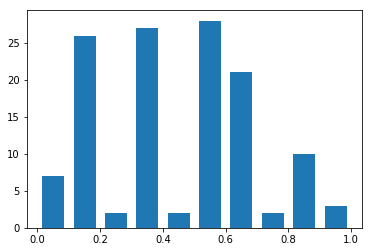

In [403]:
histogram(list(map(np.mean, observed)))

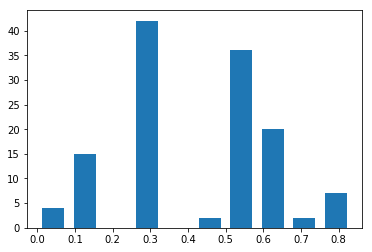

In [368]:
histogram(list(map(np.mean, control_set)))

In [397]:
with open(Path('..') / '..' / 'data' / 'clustered.pkl', 'wb') as file:
    pickle.dump(clustered, file)
    
with open(Path('..') / '..' / 'data' / 'control.pkl', 'wb') as file:
    pickle.dump(control, file)